In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/artbench/ArtBench-10.csv')
df.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/fran...,True,800,657,impressionism,train,43186
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-g...,True,521,499,impressionism,train,41151
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-le...,True,800,612,impressionism,train,9754
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-am...,True,560,336,impressionism,train,44244
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-ca...,True,2400,2322,impressionism,train,46885


In [10]:
df['path'] = df.apply(lambda x: "../../../../codes/artbench/data/artbench-10-imagefolder/{}/{}".format(x['label'], x['name']), axis=1)
df.head()

,name,artist,url,is_public_domain,length,width,label,split,cifar_index,path
0,frank-omeara_towards-night-and-winter.jpg,frank-omeara,https://uploads5.wikiart.org/00316/images/fran...,True,800,657,impressionism,train,43186,../../../../codes/artbench/data/artbench-10-im...
1,goldstein-grigoriy_morning.jpg,goldstein-grigoriy,https://uploads5.wikiart.org/images/grigoriy-g...,True,521,499,impressionism,train,41151,../../../../codes/artbench/data/artbench-10-im...
2,georges-lemmen_man-reading.jpg,georges-lemmen,https://uploads6.wikiart.org/images/georges-le...,True,800,612,impressionism,train,9754,../../../../codes/artbench/data/artbench-10-im...
3,theodor-aman_port-of-constantza-1882.jpg,theodor-aman,https://uploads6.wikiart.org/images/theodor-am...,True,560,336,impressionism,train,44244,../../../../codes/artbench/data/artbench-10-im...
4,niccolo-cannicci_il-passo-della-futa-1914.jpg,niccolo-cannicci,https://uploads3.wikiart.org/images/niccolo-ca...,True,2400,2322,impressionism,train,46885,../../../../codes/artbench/data/artbench-10-im...


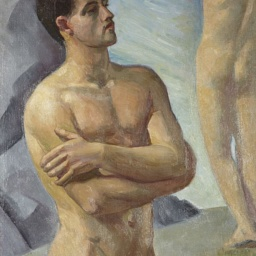

In [11]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"image": df.loc[idx_train]['path'].tolist(),
                                   "label": df.loc[idx_train]['label'].tolist(),
                                  }).cast_column("image", Image())
train_dataset[0]["image"]

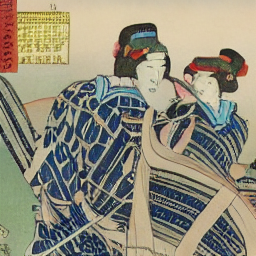

In [12]:
import pandas as pd
df = pd.DataFrame()
df['label'] = ['ukiyo_e']*500+['post_impressionism']*500
df['path'] = ['{}/{}.png'.format('../../saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "image": df['path'].tolist(),
    "label": df['label'].tolist(),
}).cast_column("image", Image()),})
val_dataset = dataset["train"]
val_dataset[0]["image"]

In [13]:
class Args():
    pretrained_model_name_or_path='lambdalabs/miniSD-diffusers'
    resolution=256
    center_crop=True
    random_flip=False
    caption_column='label'
    image_column='image'
    revision=None
    dataloader_num_workers=8
    train_batch_size=64
args=Args()

In [14]:
from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from torchvision import transforms
tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision,
                                                            local_files_only=True,)
vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", 
                                    revision=args.revision, 
                                    local_files_only=True,).half()
vae.cuda()
vae.eval()
print('done')

done


In [15]:
if True:
    image_column=args.image_column
    caption_column=args.caption_column
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            ####
            caption = 'a {} painting'.format(caption.replace("_", " ").lower())
            ####
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    # Preprocessing the datasets.
    train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

    if True:
        ####
        train_dataset = train_dataset
        ####
        train_dataset = train_dataset.with_transform(preprocess_train)
        val_dataset = val_dataset.with_transform(preprocess_train)
        print(len(train_dataset))
        print(train_dataset[0])
        ####
#     def collate_fn(examples):
#         pixel_values = torch.stack([example["pixel_values"] for example in examples])
#         pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
#         input_ids = torch.stack([example["input_ids"] for example in examples])
#         return {"pixel_values": pixel_values, "input_ids": input_ids}

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        
        input_ids_list = []
        for example in examples:
            # if np.random.rand()<0.1:
            #     input_ids_list.append(empty_inputs.input_ids[0])
            # else:
            #     input_ids_list.append(example["input_ids"])

            input_ids_list.append(example["input_ids"])

        input_ids = torch.stack(input_ids_list)
        
        return {"pixel_values": pixel_values, "input_ids": input_ids}

    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=False,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        shuffle=False,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

5000
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F52B7B0A130>, 'label': 'post_impressionism', 'pixel_values': tensor([[[ 0.1922,  0.1843,  0.1451,  ...,  0.1529,  0.0745, -0.0039],
         [ 0.1529,  0.1529,  0.1608,  ...,  0.1059,  0.0275, -0.0196],
         [ 0.1529,  0.1373,  0.1608,  ...,  0.0902,  0.0353, -0.0196],
         ...,
         [ 0.0824,  0.1059,  0.0118,  ..., -0.0118,  0.0196,  0.0196],
         [ 0.0588,  0.1216,  0.0196,  ..., -0.0588, -0.0588, -0.0667],
         [ 0.0275,  0.1294,  0.0588,  ..., -0.0824, -0.1137, -0.0902]],

        [[ 0.1922,  0.1843,  0.1451,  ...,  0.0431, -0.0353, -0.1137],
         [ 0.1529,  0.1529,  0.1608,  ..., -0.0039, -0.0824, -0.1294],
         [ 0.1529,  0.1373,  0.1608,  ..., -0.0196, -0.0745, -0.1294],
         ...,
         [ 0.0902,  0.1137,  0.0118,  ..., -0.0588, -0.0196, -0.0039],
         [ 0.0667,  0.1294,  0.0196,  ..., -0.0588, -0.0510, -0.0353],
         [ 0.0353,  0.1373,  0.0588,  ..., -

In [16]:
train_features = []

for step, batch in enumerate(train_dataloader):
    with torch.no_grad():
        image_features = vae.encode(batch["pixel_values"].to(dtype=torch.float16).cuda()).latent_dist.mode().float()
        image_features = image_features.reshape(image_features.size(0), -1)
    print(image_features.size())
    train_features.append(image_features.cpu().numpy())

torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size(

In [17]:
train_features_array = np.vstack(train_features)
train_features_array.shape

(5000, 4096)

In [18]:
val_features = []

for step, batch in enumerate(val_dataloader):
    with torch.no_grad():
        image_features = vae.encode(batch["pixel_values"].to(dtype=torch.float16).cuda()).latent_dist.mode().float()
        image_features = image_features.reshape(image_features.size(0), -1)
    print(image_features.size())
    val_features.append(image_features.cpu().numpy())

torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([64, 4096])
torch.Size([40, 4096])


In [19]:
val_features_array = np.vstack(val_features)
val_features_array.shape

(1000, 4096)

In [20]:
scores_list = []

In [21]:
scores = val_features_array.dot(train_features_array.T)
scores_list.append(scores)

In [22]:
scores = (val_features_array/np.linalg.norm(val_features_array, axis=1).reshape(-1, 1)).dot(
    (train_features_array/np.linalg.norm(train_features_array, axis=1).reshape(-1, 1)).T
)
scores_list.append(scores)

In [23]:
with open('./gen_clip.pkl', 'wb') as handle:
    pickle.dump(scores_list, handle)

In [24]:
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [25]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/sd-lora-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

In [26]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [27]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

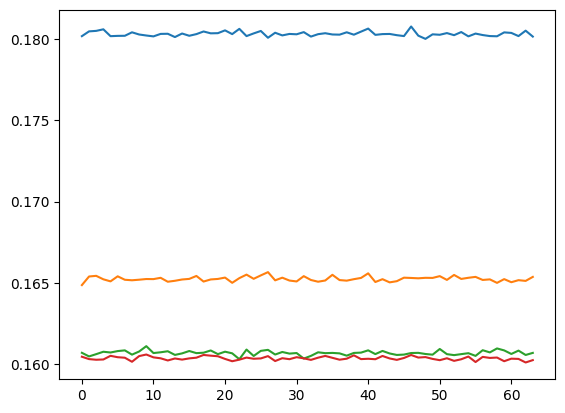

In [28]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [29]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[0]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.025 (avg p value 0.492741)


In [30]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

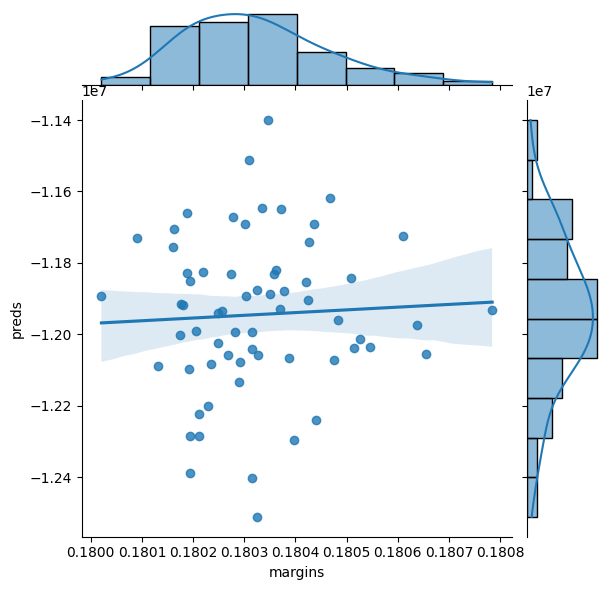

In [31]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [32]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
# k = 48
# margins = lds_testset_correctness[k:]
# infl_est_ = _masked_dot(lds_testset_correctness[:k], lds_mask_array[:k]) - _masked_dot(lds_testset_correctness[:k], ~lds_mask_array[:k])
# # infl_est_ = _masked_dot(lds_testset_correctness[:], lds_mask_array[:]) - _masked_dot(lds_testset_correctness[:], ~lds_mask_array[:])
# preds = lds_mask_array[k:] @ infl_est_.T

margins = lds_testset_correctness
infl_est_ = -scores_list[1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.026 (avg p value 0.489910)


In [33]:
my_data = {
    'margins': margins[:, 0],
    'preds': preds[:, 0]
}

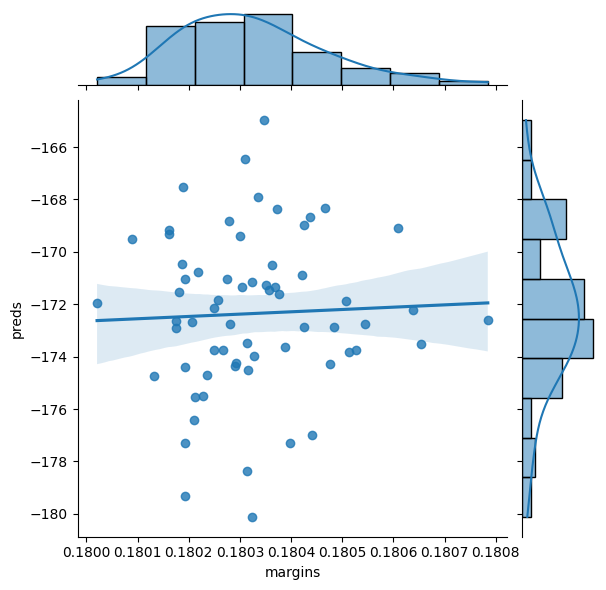

In [34]:
import seaborn as sns
sns.jointplot(data=my_data, x="margins", y="preds", kind="reg")

In [35]:
scores = scores_list[1]

In [36]:
i = 0

In [37]:
D = -scores[i]
D.shape

(5000,)

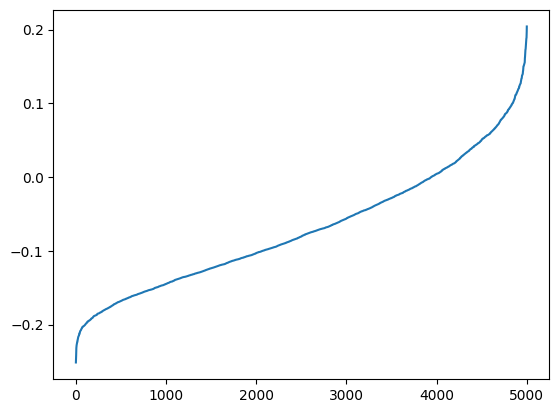

In [38]:
plt.plot(sorted(D))
# plt.axhline(y=0, c='red')

In [39]:
topK = np.arange(5000)[D.argsort()[0:5]]
topK

array([2685, 1994, 1240, 4929, 2158])

In [40]:
plot_images = []
plot_images.append(val_dataset[i]['image'])
for idx in topK:
    plot_images.append(train_dataset[int(idx)]['image'])

In [41]:
val_artist = ''
val_artist

''

In [42]:
train_artist = []
for k in topK:
    tmp_artist = ''
    train_artist.append(tmp_artist)
train_artist   

['', '', '', '', '']

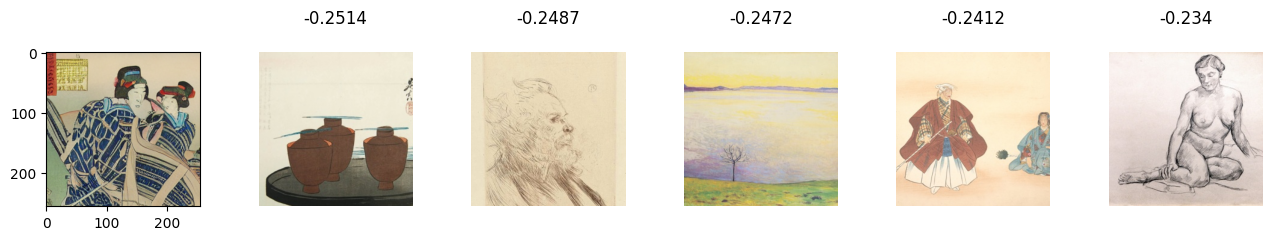

In [43]:
# full
show_images(plot_images, D[D.argsort()[0:5]], val_artist, train_artist)